<a href="https://colab.research.google.com/github/shivanth123/Malaraia_Dectection_CNN_XGBoost/blob/main/Project_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive

# Mounts Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prints the TensorFlow version
print(tf.__version__)

# Lists physical GPU devices available
print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install kaggle

In [ ]:
# Creates a directory named .kaggle in the user's home directory
!mkdir ~/.kaggle

# Creates a file named kaggle.json inside the .kaggle directory
!touch ~/.kaggle/kaggle.json

In [ ]:
# Defines a dictionary named api_token containing Kaggle username and API key
api_token = {"username":"vbk1845","key":"62e251b17785a00dcf5e39fe66fc527e"}

In [ ]:
import json

# Opens the kaggle.json file located at /root/.kaggle/kaggle.json in write mode
# Writes the contents of the api_token dictionary into the kaggle.json file using JSON format
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
# Changes the permissions of the kaggle.json file to read and write only for the owner
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloads the dataset named 'cell-images-for-detecting-malaria' from Kaggle using the Kaggle CLI
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 673M/675M [00:05<00:00, 179MB/s]
100% 675M/675M [00:05<00:00, 135MB/s]


In [ ]:
# Creates a directory named 'dataset' in the current working directory
!mkdir dataset

In [ ]:
! unzip cell-images-for-detecting-malaria.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: dataset/cell_images/cell_im

In [ ]:
import os

# Specifies the directory path where the dataset is located
path = "/content/dataset/cell_images/cell_images/"

# Retrieves a list of all files and directories in the specified path
path_data = os.listdir(path)


In [ ]:
path_data

['Uninfected', 'Parasitized']

In [ ]:
# Retrieves a list of files and directories within the 'parasitized' subdirectory
parasitized = os.listdir(path + path_data[0])

# Retrieves a list of files and directories within the 'uninfected' subdirectory
uninfected = os.listdir(path + path_data[1])


In [ ]:
# Removes the file named "Thumbs.db" from the list of parasitized images
parasitized.remove("Thumbs.db")

# Removes the file named "Thumbs.db" from the list of uninfected images
uninfected.remove("Thumbs.db")


In [ ]:
image_size = (180, 180)  # Defines the size for resizing images
batch_size = 128  # Defines the batch size for training

# Loads the dataset from the specified directory, dividing it into training and validation sets
# Resizes images to the specified size, batches them, and shuffles them during training
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/cell_images/cell_images",  # Path to the dataset directory
    validation_split=0.2,  # Specifies the validation split percentage
    subset="both",  # Uses both training and validation subsets
    seed=1337,  # Sets the random seed for shuffling
    image_size=image_size,  # Specifies the target size for images
    batch_size=batch_size,  # Specifies the batch size for training
)


Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


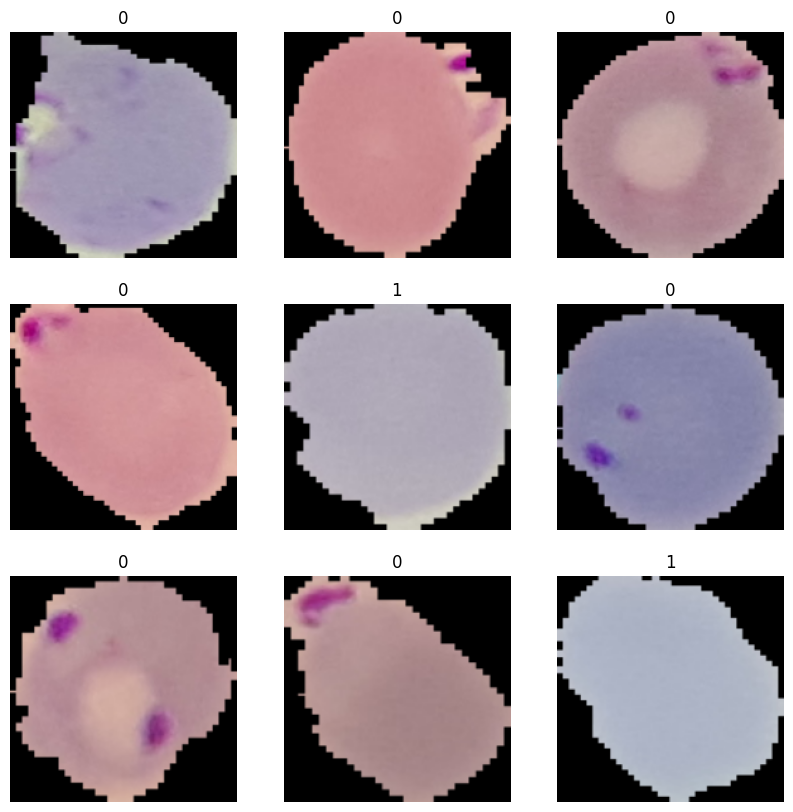

In [ ]:
import matplotlib.pyplot as plt

# Sets the figure size for the plot
plt.figure(figsize=(10, 10))

# Iterates over the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Plots the first 9 images in a 3x3 grid
    for i in range(9):
        # Creates a subplot for each image
        ax = plt.subplot(3, 3, i + 1)
        # Displays the image
        plt.imshow(images[i].numpy().astype("uint8"))
        # Sets the title of the image as its label
        plt.title(int(labels[i]))
        # Turns off axis lines and labels
        plt.axis("off")


In [ ]:
import os
import cv2
import numpy as np

# Create lists to store image data and labels
data = []  # List to store image data
labels = []  # List to store corresponding labels

# Define classes (folder names)
classes = ['Parasitized', 'Uninfected']

# Iterate through each class (folder)
for class_name in classes:
    class_path = os.path.join('/content/dataset/cell_images/cell_images', class_name)
    # Iterate through each image file in the class folder
    for filename in os.listdir(class_path):
        if filename.endswith('.png'):  # Check if the file is a PNG image
            # Read the image using OpenCV
            img = cv2.imread(os.path.join(class_path, filename))
            # Resize the image to a common size (64x64 pixels)
            img = cv2.resize(img, (64, 64))
            # Append the image data to the 'data' list
            data.append(img)
            # Append the corresponding label (index of the class in 'classes') to the 'labels' list
            labels.append(classes.index(class_name))

# Convert the lists to NumPy arrays for further processing
data = np.array(data)
labels = np.array(labels)


In [ ]:
# Print the shape of the data (image data)
print("Data shape:", data.shape)

# Print the shape of the labels
print("Labels shape:", labels.shape)

Data shape: (27558, 64, 64, 3)
Labels shape: (27558,)


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Normalize pixel values
data = data.astype('float32') / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

In [ ]:
# from keras.optimizers import SGD, Adam

# # Compile the model with SGD optimizer and categorical cross-entropy loss
# model_sgd = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(len(classes), activation='softmax')
# ])

# model_sgd.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model with SGD optimizer
# history_sgd = model_sgd.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Compile the model with Adam optimizer and categorical cross-entropy loss
# model_adam = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(len(classes), activation='softmax')
# ])

# model_adam.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model with Adam optimizer
# history_adam = model_adam.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Compare the performance of SGD and Adam optimizers
# print("SGD Optimizer:")
# print("Training Accuracy:", history_sgd.history['accuracy'])
# print("Validation Accuracy:", history_sgd.history['val_accuracy'])

# print("\nAdam Optimizer:")
# print("Training Accuracy:", history_adam.history['accuracy'])
# print("Validation Accuracy:", history_adam.history['val_accuracy'])


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initializes a sequential model
model = Sequential()

# Adds a 2D convolutional layer with 32 filters, each with a 3x3 kernel, using ReLU activation function
# Input shape is (64, 64, 3) for images of size 64x64 pixels with 3 color channels (RGB)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Adds a max pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Adds another 2D convolutional layer with 64 filters and a 3x3 kernel, using ReLU activation function
model.add(Conv2D(64, (3, 3), activation='relu'))

# Adds another max pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Adds another 2D convolutional layer with 128 filters and a 3x3 kernel, using ReLU activation function
model.add(Conv2D(128, (3, 3), activation='relu'))

# Adds another max pooling layer with a 2x2 pool size
model.add(MaxPooling2D((2, 2)))

# Flattens the output from the previous layer into a one-dimensional array
model.add(Flatten())

# Adds a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(128, activation='relu'))

# Adds a dropout layer with a dropout rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

# Adds a fully connected output layer with a softmax activation function,
# outputting probabilities for each class (number of classes determined by 'len(classes)')
model.add(Dense(len(classes), activation='softmax'))


In [ ]:
# Compiles the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
# Train your model using augmented data
#history = model.fit(augmented_data, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
689/689 [==============================] - 12s 9ms/step - loss: 0.2940 - accuracy: 0.8697 - val_loss: 0.1896 - val_accuracy: 0.9332
Epoch 2/10
689/689 [==============================] - 5s 7ms/step - loss: 0.1433 - accuracy: 0.9548 - val_loss: 0.1375 - val_accuracy: 0.9557
Epoch 3/10
689/689 [==============================] - 5s 8ms/step - loss: 0.1323 - accuracy: 0.9578 - val_loss: 0.1256 - val_accuracy: 0.9574
Epoch 4/10
689/689 [==============================] - 5s 7ms/step - loss: 0.1226 - accuracy: 0.9589 - val_loss: 0.1470 - val_accuracy: 0.9512
Epoch 5/10
689/689 [==============================] - 5s 7ms/step - loss: 0.1141 - accuracy: 0.9626 - val_loss: 0.1277 - val_accuracy: 0.9577
Epoch 6/10
689/689 [==============================] - 5s 8ms/step - loss: 0.1088 - accuracy: 0.9619 - val_loss: 0.1283 - val_accuracy: 0.9556
Epoch 7/10
689/689 [==============================] - 5s 7ms/step - loss: 0.0988 - accuracy: 0.9654 - val_loss: 0.1331 - val_accuracy: 0.9557
Epoch

In [ ]:
# import matplotlib.pyplot as plt

# # Plot training and validation accuracy for SGD optimizer
# plt.plot(history_sgd.history['accuracy'], label='SGD Training Accuracy')
# plt.plot(history_sgd.history['val_accuracy'], label='SGD Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy - SGD Optimizer')
# plt.legend()
# plt.show()

# # Plot training and validation accuracy for Adam optimizer
# plt.plot(history_adam.history['accuracy'], label='Adam Training Accuracy')
# plt.plot(history_adam.history['val_accuracy'], label='Adam Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy - Adam Optimizer')
# plt.legend()
# plt.show()

# # Compare final validation accuracies
# final_val_accuracy_sgd = history_sgd.history['val_accuracy'][-1]
# final_val_accuracy_adam = history_adam.history['val_accuracy'][-1]

# print('Final Validation Accuracy - SGD Optimizer:', final_val_accuracy_sgd)
# print('Final Validation Accuracy - Adam Optimizer:', final_val_accuracy_adam)


In [ ]:
# Evaluates the model's performance on the test data (X_test and y_test)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Evaluates the model's performance on the training data (X_train and y_train)
train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy}")


173/173 [==============================] - 1s 4ms/step - loss: 0.1691 - accuracy: 0.9572
Test Accuracy: 0.9571843147277832
689/689 [==============================] - 3s 4ms/step - loss: 0.0521 - accuracy: 0.9806
Train Accuracy: [0.052119456231594086, 0.980586051940918]


In [ ]:
# Saves the trained model to a file named 'malaria_detection_model_rf.h5'
model.save('malaria_detection_model_rf.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from keras.models import Model
from xgboost import XGBClassifier

# Load your pre-trained CNN model
cnn_model = load_model('malaria_detection_model_rf.h5')  # Replace with your model filename

# Remove the output layer to use it as a feature extractor
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Extract features from your training and testing data
cnn_features_train = cnn_feature_extractor.predict(X_train)
cnn_features_test = cnn_feature_extractor.predict(X_test)


173/173 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.decomposition import PCA

# Number of components to keep (128 in this case)
n_components = 128

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA to the CNN features from the training data
pca.fit(cnn_features_train)

# Transform the CNN features using PCA for both training and test sets
pca_cnn_features_train = pca.transform(cnn_features_train)
pca_cnn_features_test = pca.transform(cnn_features_test)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create a XGBoost classifier with 108 estimators and a random state of 0
xgb_classifier_pca = XGBClassifier(n_estimators=108, random_state=0)

# Train the XGBoost classifier on the PCA features
xgb_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))

# Predict using the XGBoost classifier on the training set
xgb_pca_train_predictions = xgb_classifier_pca.predict(pca_cnn_features_train)

# Evaluate the XGBoost classifier with PCA features on the training set
xgb_pca_train_accuracy = accuracy_score(y_train.argmax(axis=1), xgb_pca_train_predictions)
print(f"XGBoost Classifier (PCA) Training Accuracy: {xgb_pca_train_accuracy}")

# Predict using the XGBoost classifier on the test set
xgb_pca_predictions = xgb_classifier_pca.predict(pca_cnn_features_test)

# Evaluate the XGBoost classifier with PCA features on the test set
xgb_pca_accuracy = accuracy_score(y_test.argmax(axis=1), xgb_pca_predictions)
print(f"XGBoost Classifier (PCA) Accuracy: {xgb_pca_accuracy}")


XGBoost Classifier (PCA) Training Accuracy: 1.0
XGBoost Classifier (PCA) Accuracy: 0.9559143686502177


Confusion Matrix (Training Set):
 [[10982     0]
 [    0 11064]]
Confusion Matrix (Test Set):
 [[2653  144]
 [  99 2616]]


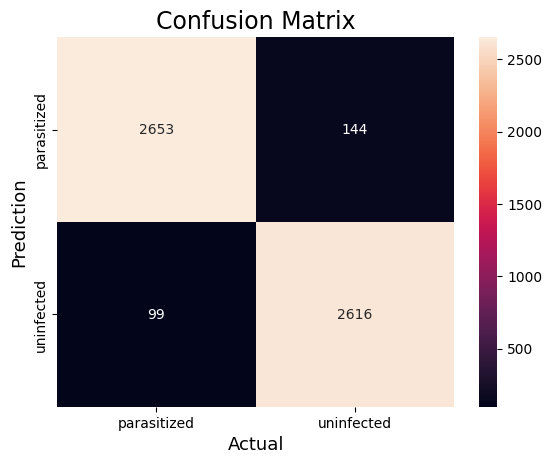

Accuracy: 0.9559143686502177
Precision: 0.9478260869565217
Recall: 0.96353591160221
F1-score: 0.9556164383561644


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate the confusion matrix for the training set
confusion_matrix_train = confusion_matrix(y_train.argmax(axis=1), xgb_pca_train_predictions)
print("Confusion Matrix (Training Set):\n", confusion_matrix_train)

# Calculate the confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_test.argmax(axis=1), xgb_pca_predictions)
print("Confusion Matrix (Test Set):\n", confusion_matrix_test)

# Plot confusion matrix for the test set using seaborn heatmap
sns.heatmap(confusion_matrix_test,
            annot=True,
            fmt='g',
            xticklabels=['parasitized', 'uninfected'],
            yticklabels=['parasitized', 'uninfected'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

# Calculate and print accuracy, precision, recall, and F1-score for the test set
accuracy = accuracy_score(y_test.argmax(axis=1), xgb_pca_predictions)
print("Accuracy:", accuracy)
precision = precision_score(y_test.argmax(axis=1), xgb_pca_predictions)
print("Precision:", precision)
recall = recall_score(y_test.argmax(axis=1), xgb_pca_predictions)
print("Recall:", recall)
F1_score = f1_score(y_test.argmax(axis=1), xgb_pca_predictions)
print("F1-score:", F1_score)

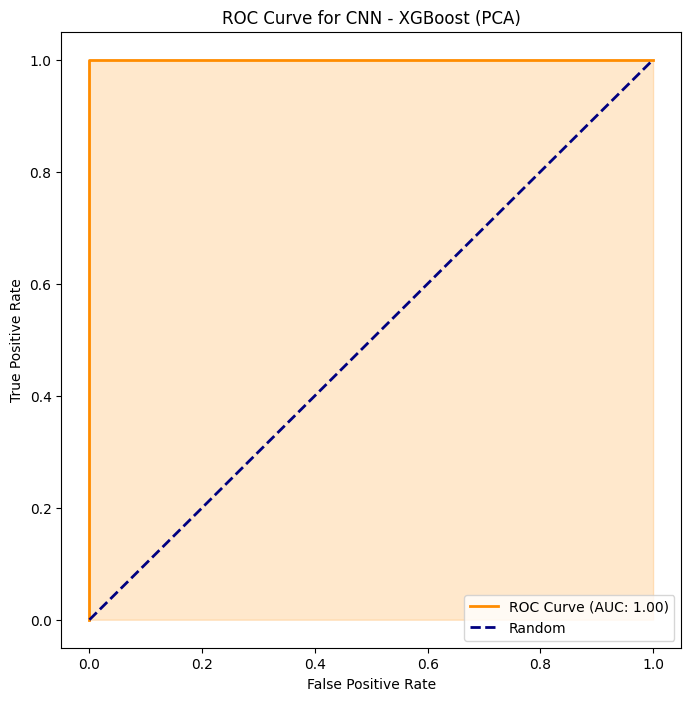

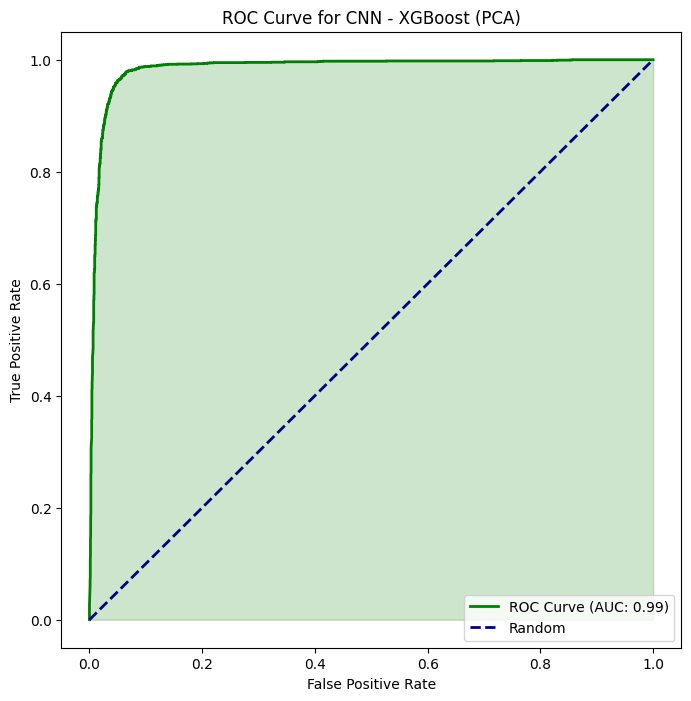

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Train the XGBoost classifier on the PCA features
xgb_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))
xgb_pca_train_predictions = xgb_classifier_pca.predict_proba(pca_cnn_features_train)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train.argmax(axis=1), xgb_pca_train_predictions)

# Plot ROC curve for training set
plt.figure(figsize=(8, 8))
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Curve (AUC: {roc_auc_train:.2f})')
plt.fill_between(fpr_train, tpr_train, alpha=0.2, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - XGBoost (PCA)')
plt.legend(loc='lower right')
plt.show()

# Predict using the XGBoost classifier on the test set
xgb_pca_predictions = xgb_classifier_pca.predict_proba(pca_cnn_features_test)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.argmax(axis=1), xgb_pca_predictions)

# Plot ROC curve for test set
plt.figure(figsize=(8, 8))
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'ROC Curve (AUC: {roc_auc_test:.2f})')
plt.fill_between(fpr_test, tpr_test, alpha=0.2, color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - XGBoost (PCA)')
plt.legend(loc='lower right')
plt.show()


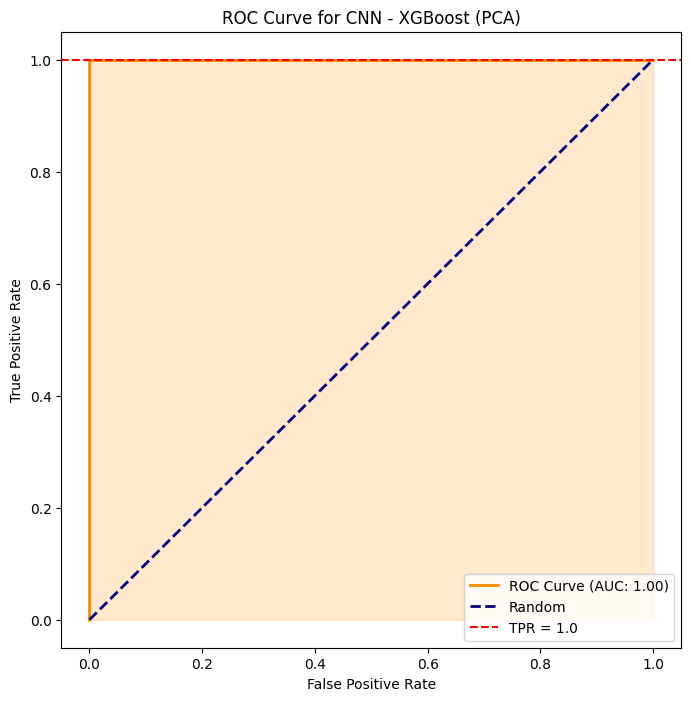

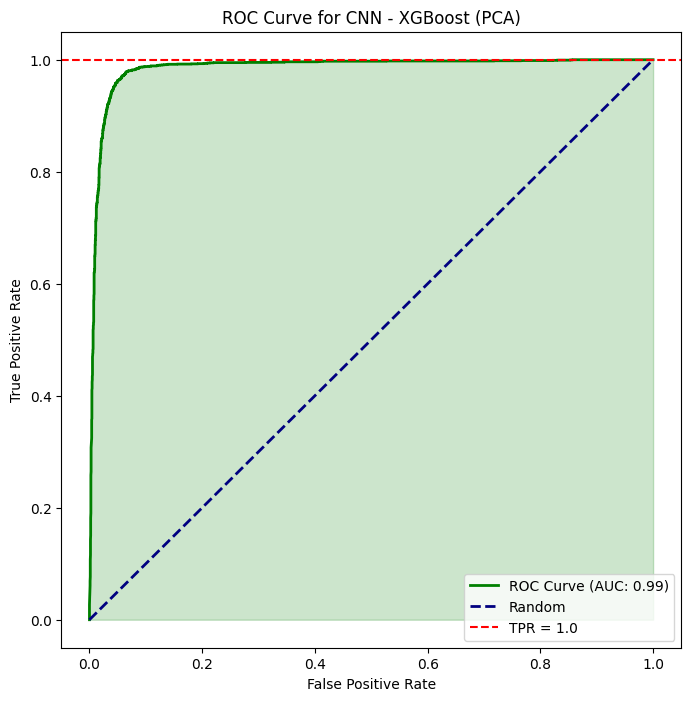

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Train the XGBoost classifier on the PCA features
xgb_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))
xgb_pca_train_predictions = xgb_classifier_pca.predict_proba(pca_cnn_features_train)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train.argmax(axis=1), xgb_pca_train_predictions)

# Plot ROC curve for training set with different color and area under the curve
plt.figure(figsize=(8, 8))
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Curve (AUC: {roc_auc_train:.2f})')
plt.fill_between(fpr_train, tpr_train, alpha=0.2, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.axhline(y=1, color='red', linestyle='--', label='TPR = 1.0')  # Add line at TPR = 1.0
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - XGBoost (PCA)')
plt.legend(loc='lower right')
plt.show()

# Predict using the XGBoost classifier on the test set
xgb_pca_predictions = xgb_classifier_pca.predict_proba(pca_cnn_features_test)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.argmax(axis=1), xgb_pca_predictions)

# Plot ROC curve for test set with different color and area under the curve
plt.figure(figsize=(8, 8))
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'ROC Curve (AUC: {roc_auc_test:.2f})')
plt.fill_between(fpr_test, tpr_test, alpha=0.2, color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.axhline(y=1, color='red', linestyle='--', label='TPR = 1.0')  # Add line at TPR = 1.0
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - XGBoost (PCA)')
plt.legend(loc='lower right')
plt.show()






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve

# Define the XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=108, random_state=0)

# Generate learning curves
sizes, training_scores, testing_scores = learning_curve(xgb_classifier, data, labels, cv=10, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))

# Calculate mean and standard deviation of training and testing scores
mean_training = np.mean(training_scores, axis=1)
std_training = np.std(training_scores, axis=1)
mean_testing = np.mean(testing_scores, axis=1)
std_testing = np.std(testing_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(sizes, mean_training, '--', color="b", label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
plt.fill_between(sizes, mean_training - std_training, mean_training + std_training, color='blue', alpha=0.1)
plt.fill_between(sizes, mean_testing - std_testing, mean_testing + std_testing, color='green', alpha=0.1)
plt.title("Learning Curve for XGBoost Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from xgboost import XGBClassifier

# Load the MNIST dataset as an example (replace with your malaria dataset)
X = data
y = labels

# Normalize and preprocess data (reshape, one-hot encoding)
X = X / 255.0
X = X.reshape(X.shape[0], 64, 64, 3)
y = to_categorical(y, num_classes=len(classes))

# Initialize lists to store performance metrics
train_accuracies = []
val_accuracies = []

# Define the range of training dataset sizes (10% to 100%)
training_sizes = np.arange(0.1, 1.1, 0.1)

for training_size in training_sizes:
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=training_size, random_state=42)

    # Define and train your CNN model (replace with your CNN model code)
    model = Sequential()
    # ... Define CNN layers and compile model
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)

    # Extract features using your CNN model
    cnn_features_train = model.predict(X_train)
    cnn_features_val = model.predict(X_val)

    # Train the XGBoost classifier on the CNN-extracted features
    xgb_classifier = XGBClassifier(n_estimators=108, random_state=0)
    xgb_classifier.fit(cnn_features_train, y_train.argmax(axis=1))

    # Make predictions and evaluate on the validation set
    y_train_pred = xgb_classifier.predict(cnn_features_train)
    y_val_pred = xgb_classifier.predict(cnn_features_val)

    train_accuracy = accuracy_score(y_train.argmax(axis=1), y_train_pred)
    val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
